In [2]:
from __future__ import print_function

import os,sys
import numpy as np
import scipy.io as scio
import tensorflow as tf
import keras
from keras.layers import Input, GRU, Dense, Flatten, Dropout, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, TimeDistributed
from keras.models import Model, load_model
import keras.backend as K
from sklearn.metrics import confusion_matrix
from keras.backend import set_session
from sklearn.model_selection import train_test_split

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
gesture = {'Push & Pull':1,
            'Sweep':2,
            'Clap':3,
            'Slide':4,
            'Draw-N (V)':5,
            'Draw-O (V)':6,
            'Draw-Rectangle':7,
            'Draw-Triangle':8,
            'Draw-Zigzag (H)':9,
            'Draw-Zigzag (V)':10,
            'Draw-N (H)':11,
            'Draw-O (H)':12,
            'Draw-1':13,
            'Draw-2':14,
            'Draw-3':15,
            'Draw-4':16,
            'Draw-5':17,
            'Draw-6':18,
            'Draw-7':19,
            'Draw-8':20,
            'Draw-9':21,
            'Draw-0':22,
            }

dataset_gesture = { '20181109':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-Zigzag (V)', 'Draw-N (V)'],
                    '20181112':['Draw-1', 'Draw-2', 'Draw-3', 'Draw-4', 'Draw-5', 'Draw-6', 'Draw-7', 'Draw-8', 'Draw-9', 'Draw-0'],
                    '20181115':['Push & Pull', 'Sweep', 'Clap', 'Draw-O (V)', 'Draw-Zigzag (V)', 'Draw-N (V)'],
                    '20181117':['Push & Pull', 'Sweep', 'Clap', 'Draw-O (V)', 'Draw-Zigzag (V)', 'Draw-N (V)'],
                    '20181118':['Push & Pull', 'Sweep', 'Clap', 'Draw-O (V)', 'Draw-Zigzag (V)', 'Draw-N (V)'],
                    '20181121':['Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181127':['Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181128':['Push & Pull', 'Sweep', 'Clap', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)'],
                    '20181130':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181204':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181205':['Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181206':['Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181208':['Push & Pull', 'Sweep', 'Clap'],
                    '20181209':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-O (H)', 'Draw-Zigzag (H)'],
                    '20181211':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-O (H)', 'Draw-Zigzag (H)'],
                    }

# Parameters

In [5]:
use_existing_model = False
fraction_for_test = 0.1
data_dir = 'BVP/'
ALL_MOTION = [i for i in range(1, 10)]
N_MOTION = len(ALL_MOTION)
T_MAX = 0
n_epochs = 30
f_dropout_ratio = 0.5
n_gru_hidden_units = 128
n_batch_size = 32
f_learning_rate = 0.001

In [32]:
def normalize_data(data_1):
    # data(ndarray)=>data_norm(ndarray): [20,20,T]=>[20,20,T]
    data_1_max = np.concatenate((data_1.max(axis=0),data_1.max(axis=1)),axis=0).max(axis=0)
    data_1_min = np.concatenate((data_1.min(axis=0),data_1.min(axis=1)),axis=0).min(axis=0)
    if (len(np.where((data_1_max - data_1_min) == 0)[0]) > 0):
        return data_1
    data_1_max_rep = np.tile(data_1_max,(data_1.shape[0],data_1.shape[1],1))
    data_1_min_rep = np.tile(data_1_min,(data_1.shape[0],data_1.shape[1],1))
    data_1_norm = (data_1 - data_1_min_rep) / (data_1_max_rep - data_1_min_rep)
    return  data_1_norm

def zero_padding(data, T_MAX):
    # data(list)=>data_pad(ndarray): [20,20,T1/T2/...]=>[20,20,T_MAX]
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        data_pad.append(np.pad(data[i], ((0,0),(0,0),(T_MAX - t,0)), 'constant', constant_values = 0).tolist())
    return np.array(data_pad)

def load_data(path_to_data, motion_sel, target_user):
    global T_MAX
    data = []
    label = []
    for data_root, data_dirs, data_files in os.walk(path_to_data):
        for data_file_name in data_files:
            file_path = os.path.join(data_root, data_file_name)
            date = data_root.split('/')[1].split('-')[0]
            try:
                data_1 = scio.loadmat(file_path)['velocity_spectrum_ro']
                ges_num = int(data_file_name.split('-')[1])
                ges_lable = dataset_gesture[date][ges_num-1]
                label_1 = gesture[ges_lable]
                user = int(data_file_name.split('-')[0].split('user')[-1])
                location = int(data_file_name.split('-')[2])
                orientation = int(data_file_name.split('-')[3])
                repetition = int(data_file_name.split('-')[4])
                # print(data_1.shape)
                
                # Select Motion
                if (label_1 not in motion_sel):
                    continue
                
                # Select User
                if user != target_user:
                    continue
                
                # Select Location
                # if (location not in [1,2,3,5]):
                #     continue

                # Select Orientation
                # if (orientation not in [1,2,4,5]):
                #     continue
                
                # Normalization
                data_normed_1 = normalize_data(data_1)
                
                # Update T_MAX
                if T_MAX < np.array(data_1).shape[2]:
                    T_MAX = np.array(data_1).shape[2]                
            except Exception as error:
                # print(type(error).__name__,' : ', error)
                continue

            # Save List
            data.append(data_normed_1.tolist())
            label.append(label_1)
            
    # Zero-padding
    data = zero_padding(data, T_MAX)

    # Swap axes
    data = np.swapaxes(np.swapaxes(data, 1, 3), 2, 3)   # [N,20,20',T_MAX]=>[N,T_MAX,20,20']
    data = np.expand_dims(data, axis=-1)    # [N,T_MAX,20,20]=>[N,T_MAX,20,20,1]

    # Convert label to ndarray
    label = np.array(label)

    # data(ndarray): [N,T_MAX,20,20,1], label(ndarray): [N,N_MOTION]
    return data, label

In [33]:
# Load data
os.mkdir('.dataset')
for user in range(1, 17+1):
    print(f'client {user} data extraction:')
    data, label = load_data(data_dir, ALL_MOTION, target_user=user)
    torch.save({'data': data, 'label': label}, f'./dataset/user{user}.pt')
    print('\nLoaded dataset of ' + str(label.shape[0]) + ' samples, each sized ' + str(data[0,:,:].shape) + '\n')


client 1 data extraction:

Loaded dataset of 5875 samples, each sized (38, 20, 20, 1)

client 2 data extraction:

Loaded dataset of 6623 samples, each sized (38, 20, 20, 1)

client 3 data extraction:

Loaded dataset of 5374 samples, each sized (38, 20, 20, 1)

client 4 data extraction:

Loaded dataset of 625 samples, each sized (38, 20, 20, 1)

client 5 data extraction:

Loaded dataset of 1375 samples, each sized (38, 20, 20, 1)

client 6 data extraction:

Loaded dataset of 1124 samples, each sized (38, 20, 20, 1)

client 7 data extraction:

Loaded dataset of 624 samples, each sized (38, 20, 20, 1)

client 8 data extraction:

Loaded dataset of 623 samples, each sized (38, 20, 20, 1)

client 9 data extraction:

Loaded dataset of 624 samples, each sized (38, 20, 20, 1)

client 10 data extraction:

Loaded dataset of 875 samples, each sized (38, 20, 20, 1)

client 11 data extraction:

Loaded dataset of 875 samples, each sized (38, 20, 20, 1)

client 12 data extraction:

Loaded dataset of 8

In [ ]:
def onehot_encoding(label, num_class):
    # label(list)=>_label(ndarray): [N,]=>[N,num_class]
    label = np.array(label).astype('int32')
    # assert (np.arange(0,np.unique(label).size)==np.unique(label)).prod()    # Check label from 0 to N
    label = np.squeeze(label)
    _label = np.eye(num_class)[label-1]     # from label to onehot
    return _label

# Split train and test
loaded_data = torch.load(f'./dataset/user{1}.pt')
[data_train, data_test, label_train, label_test] = train_test_split(data, label, test_size=fraction_for_test)
print('\nTrain on ' + str(label_train.shape[0]) + ' samples\n' +\
    'Test on ' + str(label_test.shape[0]) + ' samples\n')

# One-hot encoding for train data
label_train = onehot_encoding(label_train, N_MOTION)

In [41]:
class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 62 * 62, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 64),
            nn.ReLU()
        )

    def forward(self, x):
        return self.cnn(x)

class CustomModel(nn.Module):
    def __init__(self, num_gru_layers):
        super(CustomModel, self).__init__()

        self.num_gru_layers = num_gru_layers

        # GRU layers
        self.gru_layers = nn.ModuleList([nn.GRU(input_size=128, hidden_size=128, batch_first=True) for _ in range(num_gru_layers)])

        # CNN modules
        self.cnn_modules = nn.ModuleList([CNNModule() for _ in range(num_gru_layers)])

        # Output layer
        self.fc = nn.Linear(128 * num_gru_layers + 64 * num_gru_layers, 17)

    def forward(self, *inputs):
        assert len(inputs) == self.num_gru_layers, "Number of inputs should match the number of GRU layers"

        gru_outputs = []
        cnn_outputs = []

        # Forward pass for each GRU-CNN pair
        for i in range(self.num_gru_layers):
            cnn_output = self.cnn_modules[i](inputs[i])
            gru_output, _ = self.gru_layers[i](cnn_output)
            gru_output = gru_output[:, -1, :]  # Take the last time step

            cnn_outputs.append(cnn_output)
            gru_outputs.append(gru_output)

        # Concatenate GRU outputs and CNN outputs
        x_combined = torch.cat(gru_outputs + cnn_outputs, dim=1)

        # Output layer
        x_out = F.softmax(self.fc(x_combined), dim=1)

        return x_out

# Example: Create an instance of the model with 3 GRU layers
model = CustomModel(num_gru_layers=5)

# Display the model architecture
# print(model)

In [ ]:
def assemble_model(input_shape, n_class):
    model_input = Input(shape=input_shape, dtype='float32', name='name_model_input')    # (@,T_MAX,20,20,1)

    # Feature extraction part
    x = TimeDistributed(Conv2D(16, kernel_size=(5,5),activation='relu',data_format='channels_last',\
        input_shape=input_shape))(model_input)   # (@,T_MAX,20,20,1)=>(@,T_MAX,16,16,16)
    x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)    # (@,T_MAX,16,16,16)=>(@,T_MAX,8,8,16)
    x = TimeDistributed(Flatten())(x)   # (@,T_MAX,8,8,16)=>(@,T_MAX,8*8*16)
    x = TimeDistributed(Dense(64,activation='relu'))(x) # (@,T_MAX,8*8*16)=>(@,T_MAX,64)
    x = TimeDistributed(Dropout(f_dropout_ratio))(x)
    x = TimeDistributed(Dense(64,activation='relu'))(x) # (@,T_MAX,64)=>(@,T_MAX,64)
    x = GRU(n_gru_hidden_units,return_sequences=False)(x)  # (@,T_MAX,64)=>(@,128)
    x = Dropout(f_dropout_ratio)(x)
    model_output = Dense(n_class, activation='softmax', name='name_model_output')(x)  # (@,128)=>(@,n_class)

    # Model compiling
    model = Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
    return model

In [ ]:
# Assuming you have training data as tensors
# Replace these tensors with your actual training data
train_data1 = torch.randn((32, 10, 128, 128, 3))
train_data2 = torch.randn((32, 10, 128, 128, 3))
train_data3 = torch.randn((32, 10, 128, 128, 3))
labels = torch.randint(0, 17, (32,))

# Combine the three inputs into a tuple
train_dataset = TensorDataset(train_data1, train_data2, train_data3, labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create an instance of the model
model = CustomModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for data1, data2, data3, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data1, data2, data3)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

print('Training finished.')


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
name_model_input (InputLayer [(None, 23, 20, 20, 1)]   0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 23, 16, 16, 16)    416       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 23, 8, 8, 16)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 23, 1024)          0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 23, 64)            65600     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 23, 64)            0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 23, 64)            4160

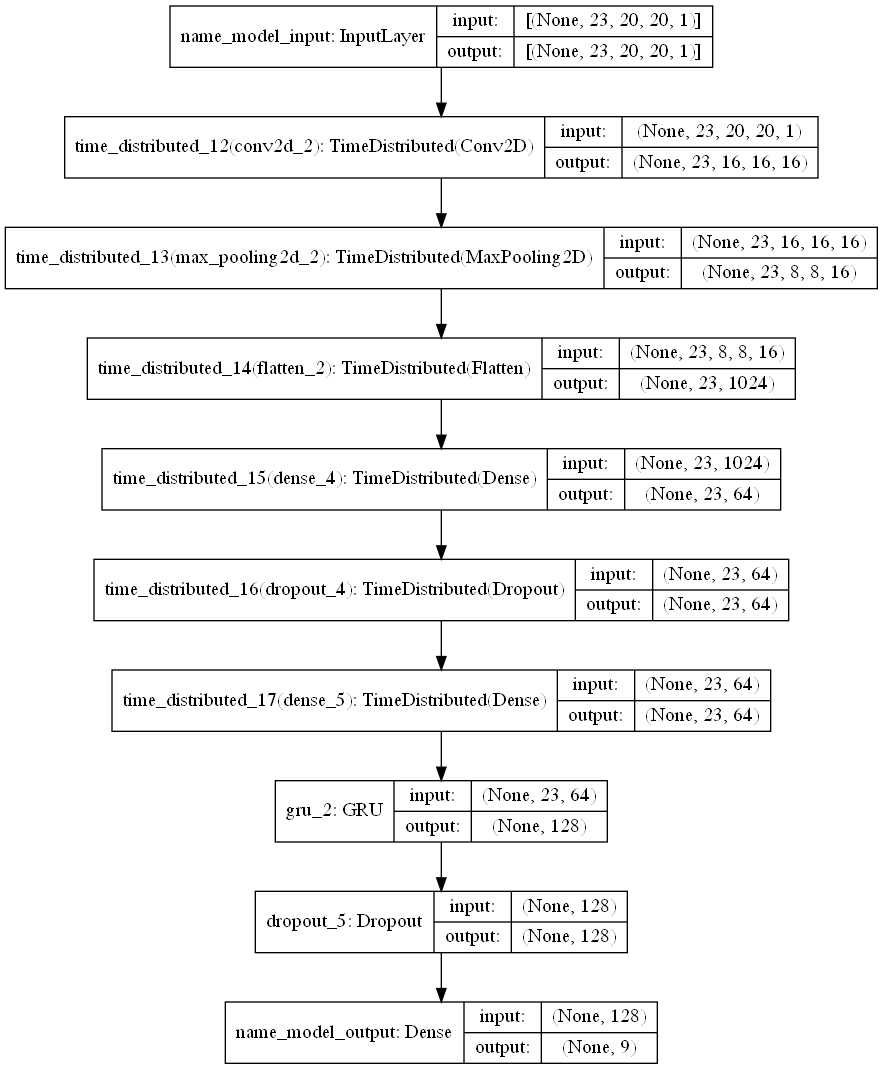

In [ ]:
# Load or fabricate model
model = assemble_model(input_shape=(T_MAX, 20, 20, 1), n_class=N_MOTION)
model.summary()
tf.keras.utils.plot_model(model, to_file='./model_arch.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.fit({'name_model_input': data_train},{'name_model_output': label_train},
        batch_size=n_batch_size,
        epochs=n_epochs,
        verbose=1,
        validation_split=0.1, shuffle=True)

In [ ]:
print('Saving trained model...')
model.save('model_widar3_trained.h5')

In [ ]:
# One-hot encoding for train data
label_train = onehot_encoding(label_train, N_MOTION)

# Load or fabricate model
if use_existing_model:
    model = load_model('model_widar3_trained.h5')
    model.summary()
else:
    model = assemble_model(input_shape=(T_MAX, 20, 20, 1), n_class=N_MOTION)
    model.summary()
    model.fit({'name_model_input': data_train},{'name_model_output': label_train},
            batch_size=n_batch_size,
            epochs=n_epochs,
            verbose=1,
            validation_split=0.1, shuffle=True)

    print('Saving trained model...')
    model.save('model_widar3_trained.h5')

In [ ]:
# Testing...
print('Testing...')
label_test_pred = model.predict(data_test)
label_test_pred = np.argmax(label_test_pred, axis = -1) + 1

# Confusion Matrix
cm = confusion_matrix(label_test, label_test_pred)
print(cm)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)
print(cm)

# Accuracy
test_accuracy = np.sum(label_test == label_test_pred) / (label_test.shape[0])
print(test_accuracy)